ใน ep ที่แล้ว [Sentiment Classification วิเคราะห์รีวิวหนัง IMDB แง่บวก แง่ลบ ด้วย Naive Bayes และ Logistic Regression](https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/) เราใช้ 1 Token ต่อ 1 คำ เรียกว่า Unigram 

แต่ใน ep นี้ เราจะมาเรียนรู้ N-Gram คือ 1 Token สามารถประกอบด้วยหลายคำ เช่น Bigram 2 คำ, Trigram 3 คำ, etc. ในงาน Sentiment Classification ด้วยอัลกอริทึมเดียวกัน ep ที่แล้ว

ข้อดีของ N-Gram คือ ทำให้โมเดลเรียนรู้ความสัมพันธ์ของคำที่ติดกันได้ดีขึ้น แต่ข้อเสียคือ จำนวน vocab Dictioinary จะเพิ่มขึ้นแบบ Exponential และถ้าใช้ N-Gram ยาวเกินไป บาง vocab ก็จะปรากฎแค่ครั้งเดียว ยิ่ง Sparse เข้าไปอีก ทำให้เราไม่สามารถใช้ N-Gram ได้ยาวตามที่ต้องการ

# 0. Install

Install Library ที่จำเป็น

In [6]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai.text และ sklearn_text ที่ใช้ในงาน [NLP](https://www.bualabs.com/archives/119/what-is-nlp-natural-language-processing-nlp-task-in-thai-nlp-ep-1/)

In [0]:
from fastai import *
from fastai.text import *
import sklearn.feature_extraction.text as sklearn_text
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import *

# 2. Dataset

ในเคสนี้เราจะใช้ IMDB Movie Review เป็นรีวิวหนังจากเว็บ IMDB ที่มีข้อความ และ คะแนนว่าเป็นแง่บวก หรือแง่ลบ

ในการพัฒนา เราจะใช้ Dataset ชุดเล็กก่อน จะได้เร็ว เมื่อเทสทุกอย่างเรียบร้อย แล้วจึงขยับไปใช้ Dataset ชุดเต็ม 

In [9]:
# IMDB Sample
path = untar_data(URLs.IMDB_SAMPLE)
path

PosixPath('/root/.fastai/data/imdb_sample')

ดูรายการไฟล์ใน Dataset

In [10]:
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

โหลดไฟล์ CSV ขึ้นมา ด้วย Pandas ใส่ DataFrame แล้วดู 5 Record แรก

In [11]:
# IMDB Sample
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


ดูสถิติข้อมูล พื้นฐาน

In [12]:
df.describe()

,label,text,is_valid
count,1000,1000,1000
unique,2,1000,2
top,negative,This movie was the most out of line and libera...,False
freq,524,1,800


พล็อตกราฟ จำนวน Label Positive vs Negative

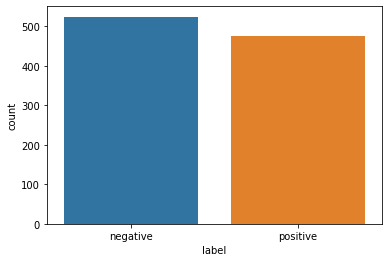

In [13]:
sns.countplot(df.label)

พล็อตกราฟจำนวน Training Set vs Validation Set

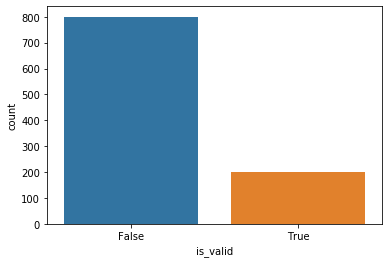

In [14]:
sns.countplot(df.is_valid)

ใช้ Fastai [DataBlock API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) TextList ในการ [Tokenize](https://www.bualabs.com/archives/119/what-is-nlp-natural-language-processing-nlp-task-in-thai-nlp-ep-1/#Tokenization), [Train / Validation Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) และ Label

In [15]:
# IMDB_Sample
movie_reviews = (TextList.from_csv(path, "texts.csv", cols="text")
                        .split_from_df(col=2)
                        .label_from_df(cols=0))

len(movie_reviews.train.x), len(movie_reviews.valid.x)

(800, 200)

ดูตัวอย่าง vocab Dictionary ที่ได้ 

In [16]:
v = movie_reviews.vocab.itos
v[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

ความหมายของ Token พิเศษ 

* UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
* PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
* BOS (xxbos) represents the beginning of a text in your dataset
* FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
* TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
* TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
* TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
* TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

จำนวนคำใน vocab Dictionary

In [17]:
vocab_len = len(v)
vocab_len

6008

# 3. Preprocessing

## 3.1 Create Training N-Gram Matrix


ใน ep ก่อน ๆ เราสร้าง Term-Document Matrix จาก Count, Sign (ทีละคำ คือ Unigram) แต่ใน ep นี้เราจะสร้าง Term-Document Matrix ที่มี N-Gram (ในเคสนี้คือ Tri-Gram แปลว่า 3) ด้วย 

ประกาศตัวแปร ที่จำเป็น

In [0]:
min_n = 1
max_n = 3

j_indices = []
indptr = []
values = []
indptr.append(0)
num_tokens = vocab_len

itongram = dict()
ngramtoi = dict()

นำข้อมูล Training Set ที่ทำ Tokenization แล้ว มาวนลูป ทุก Record, ใช้ Counter นับ Feature, วนลูปทุกความยาว N-Gram, ทุกคำศัพท์ใน vocab แล้วดูว่ามี ngram นั้นใน ngramtoi Dictionary หรือยัง ถ้าไม่มีให้เพิ่มเข้าไป เพื่อสร้างรายการของทุก N-Gram ที่เป็นไปได้จาก Training Set

แล้วนำรายการ ngram ที่ได้ มาผ่าน Counter เพื่อสร้าง Term-Document Matrix ใหม่

In [0]:
for i, doc in enumerate(movie_reviews.train.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k+n]
            
            if str(ngram) not in ngramtoi: 
                if len(ngram) == 1: 
                    num = ngram[0]
                    ngramtoi[str(ngram)] = num
                    itongram[num] = ngram
                else:
                    ngramtoi[str(ngram)] = num_tokens
                    itongram[num_tokens] = ngram
                    num_tokens += 1
            this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

ได้ค่าจาก N-Gram Counter ออกมาดังนี้

In [20]:
len(values), len(j_indices), len(indptr) - 1, len(ngramtoi)

(678885, 678885, 800, 260374)

นำมาสร้าง N-Gram Term Document Matrix แบบ Sparse Matrix เนื่องจากข้อมูล Sparse มาก ส่วนใหญ่เป็น 0

In [0]:
train_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr), 
                                                 shape=(len(indptr) - 1, len(ngramtoi)), 
                                                 dtype=int)

In [22]:
train_ngram_doc_matrix

<800x260374 sparse matrix of type '<class 'numpy.int64'>'
	with 678885 stored elements in Compressed Sparse Row format>

นำมาพล็อต Heatmap ดู จะเห็นว่า แทบจะกลายเป็นเส้นเลย เนื่องจากจำนวนคำศัพท์ใน vocab เพิ่มขึ้นมากแบบ Exponential จาก N-Gram 3, 2, 1

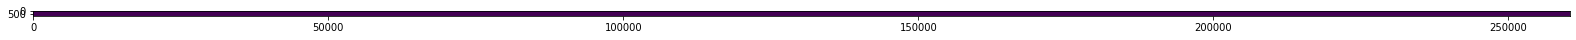

In [23]:
fig, ax = plt.subplots(figsize=(22, 2))
ax.imshow(train_ngram_doc_matrix.todense(), interpolation='nearest')
plt.tight_layout()

ซูมดู 100 Feature แรก ของ 100 ข้อมูลตัวอย่างแรก

In [0]:
np.set_printoptions(threshold=sys.maxsize)

In [25]:
train_ngram_doc_matrix.todense()[:10, 6009:6109]

matrix([[ 1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  4,  1,  1,  3,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  2, 13,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         

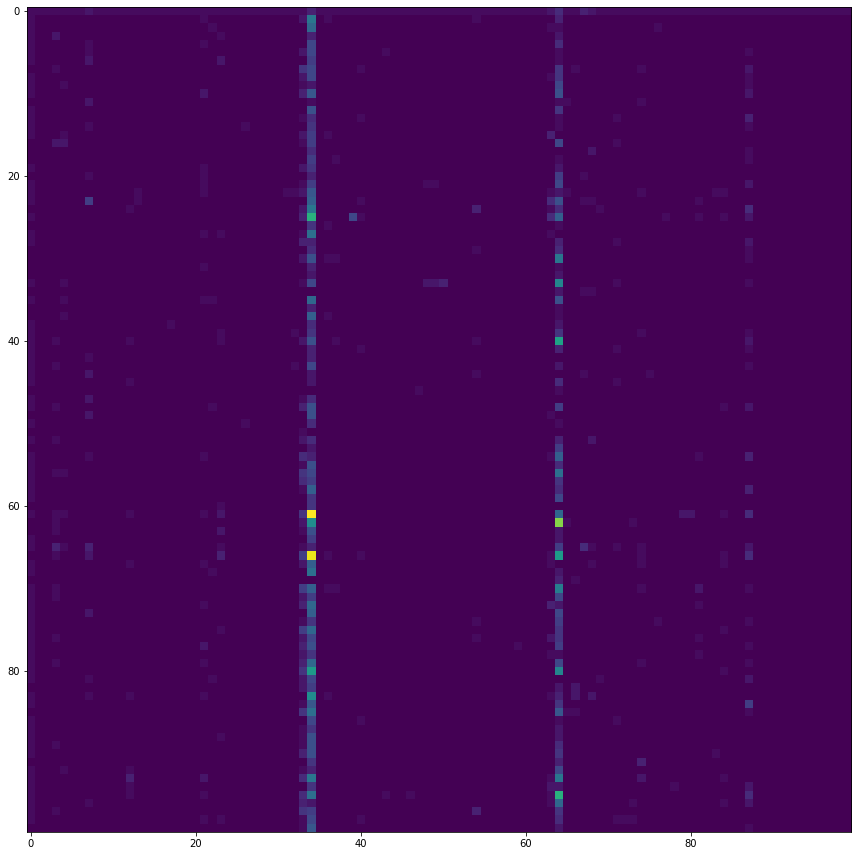

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(train_ngram_doc_matrix.todense()[:100, 6009:6109], interpolation='nearest')
plt.tight_layout()

ในกรณีนี้ จะเท่ากัน เนื่องจาก ไม่มี N-Gram ไหน Map ไป Unknown เพื่อจำกัดจำนวน vocab เหมือน ep ที่แล้ว [Sentiment Classification วิเคราะห์รีวิวหนัง IMDB แง่บวก แง่ลบ ด้วย Naive Bayes และ Logistic Regression](https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/)

In [27]:
len(ngramtoi), len(itongram)

(260374, 260374)

ลองดูตัวอย่าง N-Gram ใน Term-Document Matrix ที่ได้

### ตัวอย่าง 1

In [28]:
itongram[20005]

array([ 15,   9, 710])

In [29]:
ngramtoi[str(np.array([15, 9, 710]))]

20005

In [30]:
v[15], v[9], v[710]

('to', 'the', 'leads')

### ตัวอย่าง 2

In [31]:
itongram[20050]

array([  14,    5, 2808])

In [32]:
ngramtoi[str(np.array([14, 5, 2808]))]

20050

In [33]:
v[14], v[5], v[2808]

('of', 'xxmaj', 'celeste')

### ตัวอย่าง 3

In [34]:
itongram[20080]

array([ 23, 796,  11])

In [35]:
ngramtoi[str(np.array([23, 796,  11]))]

20080

In [36]:
v[23], v[796], v[11]

("'s", 'career', ',')

## 3.2 Create Valid N-Gram Matrix

สร้าง N-Gram Term-Document Matrix ด้วยข้อมูลจาก Validation Set โดยใช้ ngramtoi Dictionary จาก Training Set

In [0]:
j_indices = []
indptr = []
values = []
indptr.append(0)

for i, doc in enumerate(movie_reviews.valid.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) in ngramtoi:
                this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

นำค่าจาก Counter ที่ได้ มาสร้าง Term-Document Matrix ซึ่งเป็น Sparse Matrix เช่นเดียวกับด้านบน

In [0]:
valid_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

เปรียบเทียบ valid, train N-Gram Term-Document Matrix 200, 800 Record จำนวน 260374 Column เท่ากัน

In [39]:
valid_ngram_doc_matrix, train_ngram_doc_matrix

(<200x260374 sparse matrix of type '<class 'numpy.int64'>'
 	with 121600 stored elements in Compressed Sparse Row format>,
 <800x260374 sparse matrix of type '<class 'numpy.int64'>'
 	with 678885 stored elements in Compressed Sparse Row format>)

## 3.3 Save Data

การสร้าง Matrix ขนาดใหญ่แบบนี้ ค่อนข้างใช้เวลา เราจะ Save ไว้ก่อน จะได้ไม่ต้องคำนวนใหม่ทุกครั้ง

In [0]:
scipy.sparse.save_npz("train_ngram_doc_matrix.npz", train_ngram_doc_matrix)

In [0]:
scipy.sparse.save_npz("valid_ngram_doc_matrix.npz", valid_ngram_doc_matrix)

Save Dictionary ด้วย

In [0]:
with open('itongram.pickle', 'wb') as handle:
    pickle.dump(itongram, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('ngramtoi.pickle', 'wb') as handle: 
    pickle.dump(ngramtoi, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 3.4 Load Data

โหลดข้อมูลขึ้นมาไว้เหมือนเดิม

In [0]:
train_ngram_doc_matrix = scipy.sparse.load_npz("train_ngram_doc_matrix.npz")
valid_ngram_doc_matrix = scipy.sparse.load_npz("valid_ngram_doc_matrix.npz")

In [0]:
with open("itongram.pickle", "rb") as handle:
    itongram = pickle.load(handle)
with open("ngramtoi.pickle", "rb") as handle:
    ngramtoi = pickle.load(handle)

ตรวจเช็คข้อมูล

In [45]:
valid_ngram_doc_matrix, train_ngram_doc_matrix

(<200x260374 sparse matrix of type '<class 'numpy.int64'>'
 	with 121600 stored elements in Compressed Sparse Row format>,
 <800x260374 sparse matrix of type '<class 'numpy.int64'>'
 	with 678885 stored elements in Compressed Sparse Row format>)

In [46]:
len(itongram), len(ngramtoi)

(260374, 260374)

# 4. Predict

ได้ Term-Document Matrix มาแล้ว เราจะนำมาใช้อัลกอริทึมต่าง ๆ Predict เปรียบเทียบกัน ว่าจะเป็นอย่างไร

## 4.1 Naives Bayes

In [47]:
x = train_ngram_doc_matrix
y = movie_reviews.train.y

x.shape, x.getnnz(), len(y)

((800, 260374), 678885, 800)

In [48]:
positive = y.c2i['positive']
negative = y.c2i['negative']

positive, negative

(1, 0)

In [49]:
x

<800x260374 sparse matrix of type '<class 'numpy.int64'>'
	with 678885 stored elements in Compressed Sparse Row format>

k เอาไว้ limit จำนวนข้อมูล ในกรณี Dataset ขนาดใหญ่ เราจะลองข้อมูลเล็ก ๆ ก่อนจะได้เร็ว

In [0]:
k = 5000

In [51]:
pos = (y.items == positive)[:k]
neg = (y.items == negative)[:k]

pos[:10], neg[:10]

(array([False,  True, False,  True, False, False, False, False, False, False]),
 array([ True, False,  True, False,  True,  True,  True,  True,  True,  True]))

In [52]:
xx = x[:k]
xx

<800x260374 sparse matrix of type '<class 'numpy.int64'>'
	with 678885 stored elements in Compressed Sparse Row format>

คำนวน Naive Bayes

In [0]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

In [0]:
pr1 = (p1+1) / ((y.items == positive).sum() + 1)
pr0 = (p0+1) / ((y.items == negative).sum() + 1)

In [0]:
r = np.log(pr1/pr0)

In [56]:
(y.items == positive).mean(), (y.items == negative).mean()

(0.47875, 0.52125)

In [57]:
b = np.log((y.items == positive).mean() / (y.items == negative).mean())
b

-0.08505123261815539

In [0]:
pre_preds = valid_ngram_doc_matrix @ r.T + b

In [59]:
pre_preds[:10]

array([ 111.020137,   39.70486 ,    1.3799  ,   14.603319,  -30.464943,   99.644291,   25.726572, -180.516202,
         37.933098,  -92.847017])

Transpose และเปลี่ยนเป็น Boolean True > 0, False < 0

In [0]:
preds = pre_preds.T > 0

In [61]:
preds[:10]

array([ True,  True,  True,  True, False,  True,  True, False,  True, False])

เปรียบเทียบกับ Label ของ Validation Set

In [0]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [63]:
(preds == valid_labels).mean()

0.76

## 4.2 Binarized Naive Bayes

แทนที่จะใช้ Count เราจะใช้แค่ว่ามี N-Gram นี้ หรือไม่มีแทน ด้วย sign

In [0]:
trn_x_ngram_sgn = train_ngram_doc_matrix.sign()
val_x_ngram_sgn = valid_ngram_doc_matrix.sign()

limit ด้วย k เหมือนเดิม

In [0]:
xx = trn_x_ngram_sgn[:k]

คำนวน Naive Bayes ด้วยสูตรเดิม

In [0]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

In [0]:
pr1 = (p1+1) / ((y.items == positive).sum() + 1)
pr0 = (p0+1) / ((y.items == negative).sum() + 1)

In [0]:
r = np.log(pr1/pr0)

In [69]:
b = np.log((y.items == positive).mean() / (y.items == negative).mean())
b

-0.08505123261815539

In [70]:
(y.items == positive).mean(), (y.items == negative).mean()

(0.47875, 0.52125)

In [0]:
pre_preds = valid_ngram_doc_matrix @ r.T + b

In [72]:
pre_preds[:10]

array([  48.084557,   -5.809856,  -39.404141,  -18.020487,  -44.618515,   35.000107,  -19.354416, -188.235804,
        -15.890994, -104.011163])

Transpose แล้วเปลี่ยนเป็น Boolean 

In [0]:
preds = pre_preds.T > 0

In [74]:
preds[:10]

array([ True, False, False, False, False,  True, False, False, False, False])

เปรียบเทียบกับ Label ของ Validation Set

In [0]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [76]:
(preds == valid_labels).mean()

0.715

## 4.3 Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

ใช้ CountVectorizer สร้าง Term-Document Matrix

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
veczr = CountVectorizer(ngram_range=(1, 3), preprocessor=noop, tokenizer=noop, max_features=800000)

In [0]:
docs = movie_reviews.train.x

In [115]:
train_words = [[docs.vocab.itos[o] for o in doc.data] for doc in movie_reviews.train.x]
valid_words = [[docs.vocab.itos[o] for o in doc.data] for doc in movie_reviews.valid.x]

len(train_words), len(valid_words)

(800, 200)

In [116]:
%%time
train_ngram_doc = veczr.fit_transform(train_words)

CPU times: user 1.3 s, sys: 90 µs, total: 1.3 s
Wall time: 1.3 s


In [117]:
train_ngram_doc

<800x260373 sparse matrix of type '<class 'numpy.int64'>'
	with 565680 stored elements in Compressed Sparse Row format>

ดูตัวอย่าง vocab Dictionary ที่ได้ เป็น N-Gram

In [118]:
len(veczr.vocabulary_), list(islice(veczr.vocabulary_.items(), 20)), list(islice(veczr.vocabulary_.items(), 26000, 26020))

(260373,
 [('xxbos', 235215),
  ('xxmaj', 235589),
  ('un', 217511),
  ('-', 14660),
  ('xxunk', 247952),
  ('believable', 50420),
  ('!', 593),
  ('meg', 134438),
  ('ryan', 171955),
  ('does', 72621),
  ("n't", 141191),
  ('even', 78281),
  ('look', 129009),
  ('her', 101674),
  ('usual', 219401),
  ('lovable', 129862),
  ('self', 175864),
  ('in', 110056),
  ('this', 206619),
  (',', 8800)],
 [('to see xxup', 212903),
  ('see xxup h.', 175207),
  ("wells ' xxmaj", 226026),
  ("' xxmaj war", 3547),
  ('xxmaj worlds \x96', 247275),
  ('worlds \x96 and', 233978),
  ('\x96 and not', 260265),
  ('and not some', 36666),
  ('not some wholly', 146054),
  ('some wholly xxunk', 182680),
  ('wholly xxunk version', 229977),
  ('xxunk version of', 255178),
  ('version of it', 219954),
  ('of it \x96', 148987),
  ('it \x96 see', 119713),
  ('\x96 see this', 260333),
  ('see this film', 175133),
  ('this film !', 207027),
  ('tend', 190800),
  ('paul', 159166)])

In [120]:
vocab = veczr.get_feature_names()
len(vocab)

260373

N-Gram ที่พบบ่อยต้น ๆ (Dataset ชุดเล็ก)

In [0]:
topk = train_ngram_doc.max(0).todense().argsort(1)[:, -1520:-1500].tolist()[0]

In [182]:
[vocab[k] for k in topk]

['animation',
 'africans',
 'again',
 'wave to wave',
 'xxmaj melissa',
 'waves ,',
 'although',
 'xxmaj meadows',
 'almost too',
 '-- xxmaj the',
 'when xxmaj',
 'xxmaj marty',
 'west',
 ", it 's",
 "' xxmaj the",
 'xxunk , and',
 'alison',
 'alibi .',
 'alibi',
 'xxup xxunk (']

Transform ข้อมูล Validation Set ด้วย vocab Dictionary ของ Training Set

In [119]:
val_ngram_doc = veczr.transform(valid_words)
val_ngram_doc

<200x260373 sparse matrix of type '<class 'numpy.int64'>'
	with 93552 stored elements in Compressed Sparse Row format>

ดูตัวอย่าง N-Gram vocab

In [187]:
vocab[200000:200020]

['the same cult',
 'the same dance',
 'the same date',
 'the same day',
 'the same diner',
 'the same director',
 'the same directors',
 'the same enthusiasm',
 'the same film',
 'the same goes',
 'the same hall',
 'the same if',
 'the same impact',
 'the same job',
 'the same kinds',
 'the same level',
 'the same lines',
 'the same look',
 'the same message',
 'the same method']

In [190]:
vocab[100000:100020]

['he allows',
 'he allows xxmaj',
 'he almost',
 'he almost invincible',
 'he almost looks',
 'he alone',
 'he alone can',
 'he alone xxunk',
 'he already',
 'he already has',
 'he also',
 'he also ,',
 'he also directs',
 'he also follows',
 'he also forgot',
 'he also gradually',
 'he also lost',
 'he also makes',
 'he also seeks',
 'he also seems']

Fit และ Predict ด้วย Logistic Regression

In [0]:
y = movie_reviews.train.y

In [89]:
m = LogisticRegression(C=0.1, dual=True, solver='liblinear', max_iter=10000)
m.fit(train_ngram_doc, y.items);

preds = m.predict(val_ngram_doc)
(preds.T == valid_labels).mean()

0.78

## 4.4 Binarized Logistic Regression

In [90]:
m = LogisticRegression(C=0.1, dual=True, solver='liblinear', max_iter=10000)
m.fit(train_ngram_doc.sign(), y.items);

preds = m.predict(val_ngram_doc)
(preds.T == valid_labels).mean()

0.69

## 4.3/2 Logistic Regression กับ N-Gram ที่เราสร้างเอง

แทนที่จะใข้ CountVectorizer เราจะใช้ N-Gram Term-Document Matrix ที่เราวนลูปสร้างเอง จาก Counter เปรียบเทียบกัน

In [91]:
m2 = LogisticRegression(C=0.1, dual=False, solver='saga', max_iter=10000)
m2.fit(train_ngram_doc_matrix, y.items);

preds = m2.predict(valid_ngram_doc_matrix)
(preds.T == valid_labels).mean()

0.665

## 4.4/2 Binarized Logistic Regression กับ N-Gram ที่เราสร้างเอง

เราจะใช้ Binarized N-Gram Term-Document Matrix ที่เราวนลูปสร้างเอง จาก Counter เปรียบเทียบกัน

In [92]:
m2 = LogisticRegression(C=0.1, dual=True, solver='liblinear', max_iter=10000)
m2.fit(trn_x_ngram_sgn, y.items);

preds = m2.predict(val_x_ngram_sgn)
(preds.T == valid_labels).mean()

0.83

## 4.5 Logistic Regression กับ Log Count Ratio

แทนที่จะใช้ Count / Binarized เหมือนด้านบน เราจะเปลี่ยนมา Regularize Logistic Regression โดยการ Fit ด้วย Log-Count Ratio ของ Trigrams Feature แทน

In [0]:
x = train_ngram_doc_matrix.sign()
val_x = valid_ngram_doc_matrix.sign()
y = movie_reviews.train.y

In [0]:
positive = y.c2i['positive']
negative = y.c2i['negative']

In [0]:
k = 100000

In [0]:
pos = (y.items == positive)[:k]
neg = (y.items == negative)[:k]

In [0]:
xx = x[:k]

In [0]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [0]:
p0 = np.squeeze(np.array(xx[neg]).sum(0))
p1 = np.squeeze(np.array(xx[pos]).sum(0))

In [0]:
pr0 = (pr0 + 1) / ((y.items == negative).sum() + 1)
pr0 = (pr1 + 1) / ((y.items == positive).sum() + 1)

In [101]:
r = np.log(pr1/pr0)
r.shape, r[:10]

((260374,),
 array([ 5.252246e+00, -2.600782e-03,  5.257495e+00, -2.600782e-03, -2.600782e-03,  5.253566e+00,  4.892036e+00,
         3.493907e+00, -2.600782e-03,  5.253566e+00]))

In [102]:
np.exp(r)[:10]

array([190.994764,   0.997403, 192.      ,   0.997403,   0.997403, 191.247059, 133.22449 ,  32.914286,   0.997403,
       191.247059])

In [103]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())
b

-0.08505123261815539

เราจะ Normalized ด้วย r ก่อน Fit Logistic regression

In [104]:
xx.shape, r.shape, type(xx), type(r)

((800, 260374), (260374,), scipy.sparse.csr.csr_matrix, numpy.ndarray)

In [105]:
x_nb = xx.multiply(scipy.sparse.csr_matrix(r))
x_nb.shape

(800, 260374)

In [0]:
m = LogisticRegression(C=0.1, dual=False, solver='lbfgs', max_iter=10000)
m.fit(x_nb, y.items);

In [107]:
val_x_nb = val_x.multiply(scipy.sparse.csr_matrix(r))
preds = m.predict(val_x_nb)
(preds.T == valid_labels).mean()

0.75

# สรุป

* เราได้เรียนรู้ว่า N-Gram คืออะไร ตัวอย่างการสร้าง Term-Document Matrix แบบ Unigram, Bigram, และ Trigram
* เราได้เรียนรู้การประยุกต์ใช้ N-Gram มาช่วยในงาน Sentiment Classification 
* เราได้เรียนรู้การประยุกต์ใช้ N-Gram ร่วมกับอัลกอริทึม Naive Bayes และ Logistic Regression
* เราได้เปรียบเทียบการสร้าง Term-Document Matrix ของ N-Gram โดยใช้ Count และ Log Count Ratio
* เทคนิคเหล่านี้เป็นเทคนิคพื้นฐาน ที่เป็นที่นิยมก่อนยุค Deep Learning จะเป็นที่นิยม เทคนิคบางส่วนก็ถูกนำมาประยุกต์ใช้ต่อ แต่บางส่วนก็เสื่อมความนิยมลงไป

# Credit

* https://www.youtube.com/watch?v=dt7sArnLo1g&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=6&t=0s
* https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/
* https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/
* https://www.aclweb.org/anthology/P12-2018
* https://docs.fast.ai/text.data.html
* https://docs.fast.ai/text.transform.html
* https://docs.python.org/2/library/collections.html
* https://en.wikipedia.org/wiki/Naive_Bayes_classifier
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://en.wikipedia.org/wiki/N-gram
* https://web.stanford.edu/~jurafsky/slp3/3.pdf